# GEO1003 ~ Wi-Fi Fingerprinting

December 2023

Work by Tom Barbian (5100704), Der Derian Auliyaa Bainus (5941342), Corné Snoeij (5174473), Javier Martínez (6055613)

### Importing libraries

In [57]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import contextily as ctx

### Loading the data

##### Wi-Fi fingerprinting data

In [24]:
# load the files within folder /data/fingerprints into a list
wifi_path = os.getcwd() + '/data/fingerprints'
wifi_files = os.listdir(wifi_path)
wifi_files

['Ketelhuis side room.txt',
 'Serre 2023-12-08 10-53-11.txt',
 'Hall H 2023-12-11 12-51-23 .txt',
 'HALL D.txt',
 'entrance west.txt',
 'HALL R.txt',
 'BG+ half-floor.txt',
 'BK library 2023-12-11-13-41.txt',
 'Geolab 2023-12-08 09-11-59.txt',
 'Stairway (near Hall U) 2023-12-12 12-59-18.txt',
 'V 2023-12-08 09-42-29.txt',
 'management stairs.txt',
 'Hall Z 2023-12-12 13-22-50.txt',
 'Msc 2023-12-08 10-14-01.txt',
 'Hall K 2023-12-12 12-32-57.txt',
 'vrlab.txt']

In [143]:
# load the files into a list of dataframes
df_dict = {}

for file in wifi_files:
    df_dict[file] = pd.read_csv(wifi_path + '/' + file, sep='\t', header=0)
    df_dict[file].rename(columns={df_dict[file].columns[0]: "timestamp"}, inplace=True)

In [164]:
df_dict['Hall Z 2023-12-12 13-22-50.txt']

,timestamp,D0:4D:C6:F2:45:D1,"Aruba, a Hewlett Packard Enterprise Company",tudelft-dastud,Unnamed: 4,Unnamed: 5,-88,20,0,Ch 56 [5.280 GHz],Unnamed: 10,"0 Stations, 14% Channel Utilization",WiFi [Intel(R) Wi-Fi 6E AX211 160MHz]
0,12/12/2023 13:22:50,D0:4D:C6:F2:B9:C1,"Aruba, a Hewlett Packard Enterprise Company",tudelft-dastud,NaN,NaN,-77,46,0.0,Ch 6 [2.437 GHz],NaN,"0 Stations, 13% Channel Utilization",WiFi [Intel(R) Wi-Fi 6E AX211 160MHz]
1,12/12/2023 13:22:50,D0:4D:C6:F2:9A:61,"Aruba, a Hewlett Packard Enterprise Company",tudelft-dastud,NaN,NaN,-80,38,0.0,Ch 1 [2.412 GHz],NaN,"0 Stations, 28% Channel Utilization",WiFi [Intel(R) Wi-Fi 6E AX211 160MHz]
2,12/12/2023 13:22:50,D0:4D:C6:F2:B9:B2,"Aruba, a Hewlett Packard Enterprise Company",TUD-facility,NaN,NaN,-83,31,0.0,Ch 40 [5.200 GHz],NaN,"0 Stations, 8% Channel Utilization",WiFi [Intel(R) Wi-Fi 6E AX211 160MHz]
3,12/12/2023 13:22:50,1C:28:AF:5B:8E:F2,"Aruba, a Hewlett Packard Enterprise Company",TUD-facility,NaN,NaN,-81,35,0.0,Ch 56 [5.280 GHz],NaN,"0 Stations, 17% Channel Utilization",WiFi [Intel(R) Wi-Fi 6E AX211 160MHz]
4,12/12/2023 13:22:50,1C:28:AF:5C:43:E2,"Aruba, a Hewlett Packard Enterprise Company",TUD-facility,NaN,NaN,-79,40,0.0,Ch 11 [2.462 GHz],NaN,"0 Stations, 76% Channel Utilization",WiFi [Intel(R) Wi-Fi 6E AX211 160MHz]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19905,12/12/2023 13:40:55,D0:4D:C6:F2:B9:A0,"Aruba, a Hewlett Packard Enterprise Company",eduroam,NaN,NaN,-84,29,0.0,Ch 11 [2.462 GHz],NaN,"0 Stations, 14% Channel Utilization",WiFi [Intel(R) Wi-Fi 6E AX211 160MHz]
19906,12/12/2023 13:40:55,1C:28:AF:5C:43:F1,"Aruba, a Hewlett Packard Enterprise Company",tudelft-dastud,NaN,NaN,-83,31,0.0,Ch 112 [5.560 GHz],NaN,"0 Stations, 7% Channel Utilization",WiFi [Intel(R) Wi-Fi 6E AX211 160MHz]
19907,12/12/2023 13:40:55,D0:4D:C6:F2:92:C1,"Aruba, a Hewlett Packard Enterprise Company",tudelft-dastud,NaN,NaN,-83,31,1.0,Ch 1 [2.412 GHz],NaN,"1 Station, 40% Channel Utilization",WiFi [Intel(R) Wi-Fi 6E AX211 160MHz]
19908,12/12/2023 13:40:55,D0:4D:C6:F2:4F:D2,"Aruba, a Hewlett Packard Enterprise Company",TUD-facility,NaN,NaN,-88,20,0.0,Ch 40 [5.200 GHz],NaN,"0 Stations, 19% Channel Utilization",WiFi [Intel(R) Wi-Fi 6E AX211 160MHz]


In [163]:
df_dict['V 2023-12-08 09-42-29.txt']

,timestamp,MAC Address,Vendor,SSID,Access Point Name,Connected AP,Signal Strength,Quality,Station Count,Frequency,Position,Info,Adapter
0,8-12-2023 09:42:40,D0:4D:C6:F2:87:92,"Aruba, a Hewlett Packard Enterprise Company",TUD-facility,NaN,NaN,-48,89,0.0,Ch 132 [5.660 GHz],NaN,"0 Stations, 8% Channel Utilization",Wi-Fi 2 [Intel(R) Dual Band Wireless-AC 8265 #2]
1,8-12-2023 09:42:40,1C:28:AF:5B:83:F2,"Aruba, a Hewlett Packard Enterprise Company",TUD-facility,NaN,NaN,-79,40,0.0,Ch 108 [5.540 GHz],NaN,"0 Stations, 6% Channel Utilization",Wi-Fi 2 [Intel(R) Dual Band Wireless-AC 8265 #2]
2,8-12-2023 09:42:40,D0:4D:C6:F2:C7:F0,"Aruba, a Hewlett Packard Enterprise Company",eduroam,NaN,NaN,-77,46,28.0,Ch 56 [5.280 GHz],NaN,"28 Stations, 22% Channel Utilization",Wi-Fi 2 [Intel(R) Dual Band Wireless-AC 8265 #2]
3,8-12-2023 09:42:40,D0:4D:C6:F2:F2:12,"Aruba, a Hewlett Packard Enterprise Company",TUD-facility,NaN,NaN,-78,43,0.0,Ch 40 [5.200 GHz],NaN,"0 Stations, 49% Channel Utilization",Wi-Fi 2 [Intel(R) Dual Band Wireless-AC 8265 #2]
4,8-12-2023 09:42:41,4E:1B:86:4C:C4:97,Arcadyan Corporation,BWA-1CC496,NaN,NaN,-83,31,0.0,Ch 6 [2.437 GHz],NaN,"0 Stations, 1% Channel Utilization",Wi-Fi 2 [Intel(R) Dual Band Wireless-AC 8265 #2]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11266,8-12-2023 09:57:49,D0:4D:C6:F2:C7:F2,"Aruba, a Hewlett Packard Enterprise Company",TUD-facility,NaN,NaN,-70,67,0.0,Ch 56 [5.280 GHz],NaN,"0 Stations, 11% Channel Utilization",Wi-Fi 2 [Intel(R) Dual Band Wireless-AC 8265 #2]
11267,8-12-2023 09:57:49,D0:4D:C6:F2:F2:02,"Aruba, a Hewlett Packard Enterprise Company",TUD-facility,NaN,NaN,-74,57,0.0,Ch 6 [2.437 GHz],NaN,"0 Stations, 33% Channel Utilization",Wi-Fi 2 [Intel(R) Dual Band Wireless-AC 8265 #2]
11268,8-12-2023 09:57:49,D0:4D:C6:F2:9A:62,"Aruba, a Hewlett Packard Enterprise Company",TUD-facility,NaN,NaN,-79,40,0.0,Ch 1 [2.412 GHz],NaN,"0 Stations, 15% Channel Utilization",Wi-Fi 2 [Intel(R) Dual Band Wireless-AC 8265 #2]
11269,8-12-2023 09:57:49,D0:4D:C6:F2:9A:61,"Aruba, a Hewlett Packard Enterprise Company",tudelft-dastud,NaN,NaN,-79,40,0.0,Ch 1 [2.412 GHz],NaN,"0 Stations, 15% Channel Utilization",Wi-Fi 2 [Intel(R) Dual Band Wireless-AC 8265 #2]


In [153]:
df_dict['Stairway (near Hall U) 2023-12-12 12-59-18.txt'].columns

Index(['timestamp', 'MAC Address', 'Vendor', 'SSID', 'Access Point Name',
       'Connected AP', 'Signal Strength', 'Quality', 'Station Count',
       'Frequency', 'Position', 'Info', 'Adapter'],
      dtype='object')

##### GNSS nmea data

In [146]:
# This function was coded by Lars, but modified to save to dataframe

def get_sat_values(filename):
    PDOP, HDOP, VDOP, latitude, longitude, num_used_satellites, altitude = [], [], [], [], [], [], []

    with open(filename, 'r') as file:
        lines = file.readlines()
        # divide messages
        messages = [lines[i:i + 7] for i in range(0, len(lines), 7)]

        for message in messages:
            PDOP.append(float(message[0].split(',')[15]))
            HDOP.append(float(message[0].split(',')[16]))
            VDOP.append(float(message[0].split(',')[17][:3]))
            latitude.append(float(message[6].split(',')[2:3][0]))
            longitude.append(float(message[6].split(',')[4:5][0]))
            num_used_satellites.append(int(message[6].split(',')[6]))
            altitude.append(float(message[6].split(',')[9:10][0]))

    # Create a DataFrame
    df = pd.DataFrame({
        'PDOP': PDOP,
        'HDOP': HDOP,
        'VDOP': VDOP,
        'latitude': latitude,
        'longitude': longitude,
        'num_used_satellites': num_used_satellites,
        'altitude': altitude
    })

    return df

In [147]:
# load the files within folder /data/fingerprints into a list
nmea_path = os.getcwd() + '/data/nmea'
nmea_files = os.listdir(nmea_path)
nmea_files

['Hall H nmea.log',
 'Stairway (near Hall U) nmea.log',
 'Hall Z nmea.log',
 'Hall K nmea.log']

In [148]:
# load the nmea files into a list of dataframes
nmea_dict = {}

for file in nmea_files:
    nmea_dict[file] = get_sat_values(nmea_path + '/' + file)
    # divide latitude and longitude by 100 to get the correct value
    nmea_dict[file]['latitude'] = nmea_dict[file]['latitude'] / 100
    nmea_dict[file]['longitude'] = nmea_dict[file]['longitude'] / 100
    nmea_dict[file]['ID'] = file

In [149]:
nmea_dict['Hall K nmea.log']

,PDOP,HDOP,VDOP,latitude,longitude,num_used_satellites,altitude,ID
0,11.2,10.5,3.8,52.003689,4.222611,12,1.1,Hall K nmea.log
1,7.7,7.0,3.2,52.003696,4.222625,12,1.0,Hall K nmea.log
2,7.5,7.0,2.8,52.003697,4.222627,12,1.0,Hall K nmea.log
3,7.5,7.0,2.6,52.003697,4.222627,12,1.1,Hall K nmea.log
4,7.4,7.0,2.3,52.003697,4.222627,12,1.0,Hall K nmea.log
...,...,...,...,...,...,...,...,...
166,7.0,7.0,0.5,52.003688,4.222605,12,1.3,Hall K nmea.log
167,7.0,7.0,0.5,52.003692,4.222613,12,1.3,Hall K nmea.log
168,7.0,7.0,0.5,52.003701,4.222623,12,1.3,Hall K nmea.log
169,7.0,7.0,0.5,52.003701,4.222625,12,1.3,Hall K nmea.log


### A. Radio Mapping Phase

BK-City floor plan can be found [here.](https://www.tudelft.nl/bk/over-faculteit/het-gebouw/plattegrond/)

##### A1. Scatterplots of GNSS accuracy
Illuminate the estimated GNSS accuracy of this indoor location through a visual representation in
a scatterplot. Don't forget to include key metrics like standard deviation, HDOP, and VDOP.

In [157]:
def print_statistics(dict):
    # Create table with mean, std of lat, lon, HDOP, VDOP, PDOP for each measurement
    statistics_dfs = []
    for key, value in dict.items():
        # Calculate the mean and std for each dataframe
        statistics_df = value.groupby('ID').agg({
            'latitude': ['mean', 'std'],
            'longitude': ['mean', 'std'],
            'HDOP': ['mean', 'std'],
            'VDOP': ['mean', 'std'],
            'PDOP': ['mean', 'std']
        }).reset_index()
        # Add the measurement name to the dataframe at first column
        statistics_df.insert(0, 'measurement', key)
        statistics_dfs.append(statistics_df)

    result_df = pd.concat(statistics_dfs, axis=0)
    result_df = result_df.drop(columns=['ID'], level=0)

    return result_df

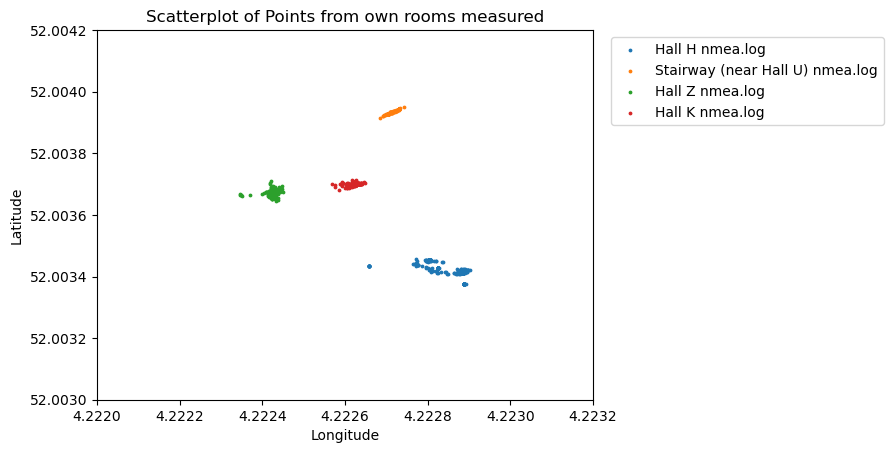

In [159]:
# plot latitude and longitude for each of the nmea files in one scatterplot with different colors
for key, df in nmea_dict.items():
    plt.scatter(df['longitude'], df['latitude'], label=key, s=3)

plt.xlim(4.222, 4.2232)
plt.ylim(52.003, 52.0042)

plt.ticklabel_format(useOffset=False)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scatterplot of Points from own rooms measured')
plt.legend(loc='upper right', bbox_to_anchor=(1.6, 1))

# Show the plot
plt.show()

In [160]:
print("Statistics table")
print_statistics(nmea_dict)

Statistics table


measurement   latitude           longitude            \
                                         mean       std      mean       std   
0                  Hall H nmea.log  52.003425  0.000023  4.222848  0.000044   
0  Stairway (near Hall U) nmea.log  52.003934  0.000007  4.222715  0.000012   
0                  Hall Z nmea.log  52.003673  0.000011  4.222423  0.000015   
0                  Hall K nmea.log  52.003700  0.000004  4.222622  0.000013   

       HDOP                VDOP                PDOP            
       mean       std      mean       std      mean       std  
0  1.667746  1.327621  0.475777  0.465847  1.771632  1.368019  
0  7.193913  0.744723  1.138261  0.664723  7.292174  0.815007  
0  7.155618  0.860690  1.206180  0.783600  7.280337  0.935735  
0  7.020468  0.267652  0.815205  0.505386  7.069006  0.332952

##### A2. Comparison of Wi-Fi fingerprinting from two proximate (geographically) locations
Gauge the degree of similarity between these fingerprints. Alternatively, on a broader scale, assess
the 'distance' between the 32 identifiable places in RSS-space. In essence, explore how
distinguishable these places are from each other.

We would like to assess the degree of similarity between two rooms: ROOM Z and ROOM V, those rooms are next to each other in the BK building. First we'll calculate the distance between the two rooms by comparing the average longitude and latitude.

In [176]:
# calculate distance between two points
point_Z = (52.003673, 4.222423)
point_V = (52.006130, 4.370520)

# calculate the distance between the two points
from geopy.distance import geodesic
distance = geodesic(point_Z, point_V).kilometers
print("Distance between the two rooms is: ", round(distance, 2), "kilometers.")

Distance between the two rooms is:  10.17 kilometers.
